In [76]:
import matplotlib.pyplot as plt
import numpy as np
import torch 
from stand_da_package.gen_data import gen_data
from stand_da_package.model import WDGRL, AutoEncoder

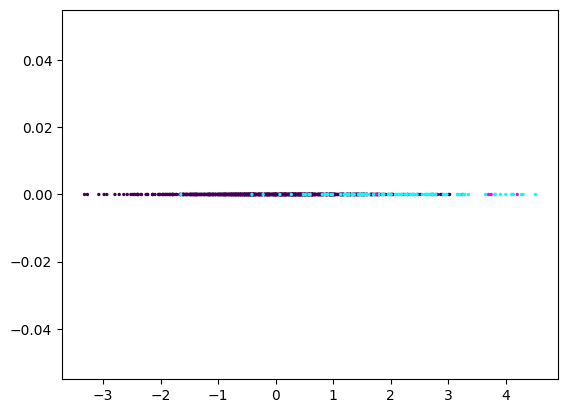

In [77]:

"""Create synthetic dataset and dataloaders for domain adaptation."""
# Create datasets
ns, nt, d = 1000, 100, 10

xs, ys, _ = gen_data(0, [0, 0.5, 1, 1.5, 2], ns, d)
xt, yt, _ = gen_data(2, [0, 0.5, 1, 1.5, 2], nt, d)

plt.scatter(xs[:, 0], np.zeros_like(xs[:, 0]), c=ys, cmap='viridis', s=2)
plt.scatter(xt[:, 0], np.zeros_like(xt[:, 0]), c=yt, cmap='cool', s=2)
plt.show()

In [78]:
# Convert to PyTorch tensors
xs = torch.DoubleTensor(xs)
ys = torch.LongTensor(ys)
xt = torch.DoubleTensor(xt)
yt = torch.LongTensor(yt)

from torch.utils.data import DataLoader, TensorDataset 
source_dataset = TensorDataset(xs, ys)
target_dataset = TensorDataset(xt, yt)
source_loader = DataLoader(source_dataset, batch_size=16, shuffle=True, drop_last=True)
target_loader = DataLoader(target_dataset, batch_size=16, shuffle=True, drop_last=True)

In [79]:
generator_hidden_dims = [50, 10]
critic_hidden_dims = [10]
model = WDGRL(input_dim=d, generator_hidden_dims=generator_hidden_dims, critic_hidden_dims=critic_hidden_dims)
num_epochs = 5
losses, source_critic_scores, target_critic_scores = model.train(source_loader, target_loader, num_epochs=num_epochs, dc_iter=10)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5 | Loss: 0.0071413558786617036
--------------------------------
Epoch 2/5 | Loss: 0.005939017764593353
--------------------------------
Epoch 3/5 | Loss: 0.010018775742724495
--------------------------------
Epoch 4/5 | Loss: 0.0080973688652348
--------------------------------
Epoch 5/5 | Loss: 0.0190895309839637
--------------------------------


In [80]:
# Define a dictionary with all the necessary components
checkpoint = {
    'generator_state_dict': model.generator.state_dict(),
    'critic_state_dict': model.critic.state_dict(),
    'device': model.device,
}
index = None

with open("model/wdgrl_models.txt", "r") as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        words = line[:-1].split("/")
        if words[1] == str(generator_hidden_dims) and words[2] == str(critic_hidden_dims):
            index = i
            break
if index is None:
    with open("model/wdgrl_models.txt", "r") as f:
        index = len(f.readlines())
    with open("model/wdgrl_models.txt", "a") as f:
        f.write(f"{index}/{generator_hidden_dims}/{critic_hidden_dims}\n")
# Save the checkpoint
torch.save(checkpoint, f"model/wdgrl_{index}.pth")
print("Model saved successfully!")

Model saved successfully!


In [81]:
xs_hat = model.extract_feature(xs.to(model.device))
xt_hat = model.extract_feature(xt.to(model.device))
x_hat = torch.cat((xs_hat, xt_hat), dim=0)

In [82]:
input_dim = generator_hidden_dims[-1]
encoder_hidden_dims = [input_dim, 8, 4, 2]
decoder_hidden_dims = [2, 4, 8, input_dim]
batch_size = 16
num_epochs = 10

model = AutoEncoder(input_dim, encoder_hidden_dims, decoder_hidden_dims)
dataset = torch.utils.data.TensorDataset(x_hat)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
losses = model.train(data_loader=data_loader, num_epochs = num_epochs)

Epoch 1/10 | Loss: 0.005139683555643041
Epoch 2/10 | Loss: 0.0034431122102065214
Epoch 3/10 | Loss: 0.0030302633155345985
Epoch 4/10 | Loss: 0.0026551948790496044
Epoch 5/10 | Loss: 0.002159752990106953
Epoch 6/10 | Loss: 0.0027260339218142483
Epoch 7/10 | Loss: 0.002021779011456279
Epoch 8/10 | Loss: 0.0030791412576041933
Epoch 9/10 | Loss: 0.002523824180575884
Epoch 10/10 | Loss: 0.002568604402281364


In [84]:
checkpoint = {
    'state_dict': model.state_dict(),
    'device': model.device,
}
index = None

with open("model/ae_models.txt", "r") as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        words = line[:-1].split("/")
        if words[1] == str(input_dim) and words[2] == str(encoder_hidden_dims) and words[3] == str(decoder_hidden_dims):
            index = i
            break
if index is None:
    with open("model/ae_models.txt", "r") as f:
        index = len(f.readlines())
    with open("model/ae_models.txt", "a") as f:
        f.write(f"{index}/{input_dim}/{encoder_hidden_dims}/{decoder_hidden_dims}\n")
# Save the checkpoint
torch.save(checkpoint, f"model/ae_{index}.pth")
print("Model saved successfully!")


Model saved successfully!
